#Tic-Tac-Toe AI Agent

##Title

Tic-Tac-Toe AI Agent (DQN) — ANN Course Project

##Imports & Setup

In [10]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque

##Utility Functions replace to Envierments

In [11]:
def init_board():
    return [' ' for _ in range(9)]

def available_actions(board):
    return [i for i, s in enumerate(board) if s == ' ']

def board_to_state(board):
    """Convert board to numerical state for NN input"""
    state = np.zeros(9, dtype=np.float32)
    for i, cell in enumerate(board):
        if cell == 'X':
            state[i] = 1.0
        elif cell == 'O':
            state[i] = -1.0
    return state

def check_winner(board):
    wins = [
        (0,1,2), (3,4,5), (6,7,8),
        (0,3,6), (1,4,7), (2,5,8),
        (0,4,8), (2,4,6)
    ]
    for a,b,c in wins:
        if board[a] == board[b] == board[c] != ' ':
            return board[a]
    return None

def is_draw(board):
    return ' ' not in board

def print_board(board):
    print("\n")
    for i in range(0, 9, 3):
        print(f" {board[i]} | {board[i+1]} | {board[i+2]} ")
        if i < 6:
            print("-----------")
    print()


##NeuralNetwork

In [12]:
class NeuralNetwork:
    """Multi-Layer Perceptron for Q-function approximation"""

    def __init__(self, input_size=9, hidden_size=128, output_size=9, learning_rate=0.001):
        # He initialization
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size)
        self.b1 = np.zeros(hidden_size)

        self.W2 = np.random.randn(hidden_size, hidden_size) * np.sqrt(2.0 / hidden_size)
        self.b2 = np.zeros(hidden_size)

        self.W3 = np.random.randn(hidden_size, output_size) * np.sqrt(2.0 / hidden_size)
        self.b3 = np.zeros(output_size)

        self.lr = learning_rate
        self.cache = {}

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return (x > 0).astype(np.float32)

    def forward(self, state):
        """Forward pass"""
        z1 = state @ self.W1 + self.b1
        a1 = self.relu(z1)

        z2 = a1 @ self.W2 + self.b2
        a2 = self.relu(z2)

        q_values = a2 @ self.W3 + self.b3

        self.cache = {
            'state': state,
            'z1': z1, 'a1': a1,
            'z2': z2, 'a2': a2,
            'q_values': q_values
        }
        return q_values

    def backward(self, action, td_error):
        """Backprop using TD error"""
        state = self.cache['state']
        a1 = self.cache['a1']
        a2 = self.cache['a2']
        z1 = self.cache['z1']
        z2 = self.cache['z2']

        dq = np.zeros(9, dtype=np.float32)
        dq[action] = td_error

        dW3 = np.outer(a2, dq)
        db3 = dq

        da2 = dq @ self.W3.T
        dz2 = da2 * self.relu_derivative(z2)
        dW2 = np.outer(a1, dz2)
        db2 = dz2

        da1 = dz2 @ self.W2.T
        dz1 = da1 * self.relu_derivative(z1)
        dW1 = np.outer(state, dz1)
        db1 = dz1

        # Gradient step (note: your original uses "+="; keeping same behavior)
        self.W3 += self.lr * dW3
        self.b3 += self.lr * db3

        self.W2 += self.lr * dW2
        self.b2 += self.lr * db2

        self.W1 += self.lr * dW1
        self.b1 += self.lr * db1

    def copy_weights_from(self, other_nn):
        self.W1 = other_nn.W1.copy()
        self.b1 = other_nn.b1.copy()
        self.W2 = other_nn.W2.copy()
        self.b2 = other_nn.b2.copy()
        self.W3 = other_nn.W3.copy()
        self.b3 = other_nn.b3.copy()

##ReplayBuffer

In [13]:
class ReplayBuffer:
    """Store and sample experiences for training"""

    def __init__(self, max_size=10000):
        self.buffer = deque(maxlen=max_size)

    def add(self, state, action, reward, next_state, done, available_next_actions):
        self.buffer.append((state, action, reward, next_state, done, available_next_actions))

    def sample(self, batch_size):
        return random.sample(self.buffer, min(batch_size, len(self.buffer)))

    def size(self):
        return len(self.buffer)




##DQNAgent

In [14]:
class DQNAgent:
    def __init__(self, learning_rate=0.001, gamma=0.9, epsilon=0.3,
                 buffer_size=10000, batch_size=32, target_update_freq=100):
        self.q_network = NeuralNetwork(9, 128, 9, learning_rate=learning_rate)
        self.target_network = NeuralNetwork(9, 128, 9, learning_rate=learning_rate)
        self.target_network.copy_weights_from(self.q_network)

        self.replay_buffer = ReplayBuffer(max_size=buffer_size)

        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.9995
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        self.training_steps = 0

    def select_action(self, state, available_actions, explore=True):
        """Epsilon-greedy"""
        if explore and random.random() < self.epsilon:
            return random.choice(available_actions)

        q_values = self.q_network.forward(state)
        q_values_masked = q_values.copy()
        for i in range(9):
            if i not in available_actions:
                q_values_masked[i] = -np.inf
        return int(np.argmax(q_values_masked))

    def store_experience(self, state, action, reward, next_state, done, available_next_actions):
        self.replay_buffer.add(state, action, reward, next_state, done, available_next_actions)

    def train_on_batch(self):
        if self.replay_buffer.size() < self.batch_size:
            return

        batch = self.replay_buffer.sample(self.batch_size)

        for state, action, reward, next_state, done, available_next_actions in batch:
            current_q = self.q_network.forward(state)[action]

            if done:
                target_q = reward
            else:
                next_q_values = self.target_network.forward(next_state)
                for i in range(9):
                    if i not in available_next_actions:
                        next_q_values[i] = -np.inf
                max_next_q = np.max(next_q_values)
                target_q = reward + self.gamma * max_next_q

            td_error = target_q - current_q
            self.q_network.backward(action, td_error)

        self.training_steps += 1
        if self.training_steps % self.target_update_freq == 0:
            self.target_network.copy_weights_from(self.q_network)
            print(f"  → Target network updated at step {self.training_steps}")

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


##Opponents

In [15]:
def random_opponent(board):
    actions = available_actions(board)
    if actions:
        board[random.choice(actions)] = 'O'

def smart_opponent(board):
    actions = available_actions(board)

    # Try to win
    for action in actions:
        board[action] = 'O'
        if check_winner(board) == 'O':
            return
        board[action] = ' '

    # Block X
    for action in actions:
        board[action] = 'X'
        if check_winner(board) == 'X':
            board[action] = 'O'
            return
        board[action] = ' '

    # Random
    board[random.choice(actions)] = 'O'


##Training

In [16]:
def train_agent(episodes=50000, opponent_fn=random_opponent, log_every=1000):
    agent = DQNAgent(
        learning_rate=0.001, gamma=0.9, epsilon=0.3,
        buffer_size=10000, batch_size=32, target_update_freq=100
    )

    wins = losses = draws = 0
    win_rate_history = []
    checkpoints = []  # x-axis points

    print(f"Training DQN Agent for {episodes} episodes...")
    print("Architecture: 9 → 128 → 128 → 9 (MLP)")
    print("Features: Experience Replay Buffer + Target Network\n")

    for ep in range(episodes):
        board = init_board()
        state = board_to_state(board)
        done = False

        while not done:
            # Agent (X)
            actions = available_actions(board)
            action = agent.select_action(state, actions, explore=True)
            board[action] = 'X'

            if check_winner(board) == 'X':
                agent.store_experience(state, action, 1.0, board_to_state(board), True, [])
                wins += 1
                done = True
                break

            if is_draw(board):
                agent.store_experience(state, action, 0.5, board_to_state(board), True, [])
                draws += 1
                done = True
                break

            # Opponent (O)
            opponent_fn(board)
            next_state = board_to_state(board)

            if check_winner(board) == 'O':
                agent.store_experience(state, action, -1.0, next_state, True, [])
                losses += 1
                done = True
                break

            if is_draw(board):
                agent.store_experience(state, action, 0.5, next_state, True, [])
                draws += 1
                done = True
                break

            # Continue
            next_actions = available_actions(board)
            agent.store_experience(state, action, 0.0, next_state, False, next_actions)
            state = next_state

        agent.train_on_batch()
        agent.decay_epsilon()

        if (ep + 1) % log_every == 0:
            total = wins + losses + draws
            win_rate = wins / total if total else 0.0
            win_rate_history.append(win_rate)
            checkpoints.append(ep + 1)

            print(f"Episode {ep+1}: WinRate={win_rate:.3f} | W={wins} L={losses} D={draws} | "
                  f"ε={agent.epsilon:.4f} | Buffer={agent.replay_buffer.size()}")

            wins = losses = draws = 0

    print("Training complete.")
    return agent, checkpoints, win_rate_history


##Run Training

In [17]:
trained_agent, checkpoints, win_rate_history = train_agent(
    episodes=50000,
    opponent_fn=random_opponent,
    log_every=1000
)


Training DQN Agent for 50000 episodes...
Architecture: 9 → 128 → 128 → 9 (MLP)
Features: Experience Replay Buffer + Target Network

  → Target network updated at step 100
  → Target network updated at step 200
  → Target network updated at step 300
  → Target network updated at step 400
  → Target network updated at step 500
  → Target network updated at step 600
  → Target network updated at step 700
  → Target network updated at step 800
  → Target network updated at step 900
Episode 1000: WinRate=0.800 | W=800 L=133 D=67 | ε=0.1819 | Buffer=3732
  → Target network updated at step 1000
  → Target network updated at step 1100
  → Target network updated at step 1200
  → Target network updated at step 1300
  → Target network updated at step 1400
  → Target network updated at step 1500
  → Target network updated at step 1600
  → Target network updated at step 1700
  → Target network updated at step 1800
  → Target network updated at step 1900
Episode 2000: WinRate=0.898 | W=898 L=52 D=50

##Evaluation

In [18]:
def evaluate_agent(agent, games=1000, opponent_fn=random_opponent):
    wins = losses = draws = 0

    for _ in range(games):
        board = init_board()

        while True:
            state = board_to_state(board)
            actions = available_actions(board)
            action = agent.select_action(state, actions, explore=False)
            board[action] = 'X'

            if check_winner(board) == 'X':
                wins += 1
                break
            if is_draw(board):
                draws += 1
                break

            opponent_fn(board)

            if check_winner(board) == 'O':
                losses += 1
                break
            if is_draw(board):
                draws += 1
                break

    print(f"\n=== Evaluation ({games} games) ===")
    print(f"Wins: {wins} ({wins/games*100:.1f}%)")
    print(f"Losses: {losses} ({losses/games*100:.1f}%)")
    print(f"Draws: {draws} ({draws/games*100:.1f}%)")


##Evaluate result

In [19]:
evaluate_agent(trained_agent, games=1000, opponent_fn=random_opponent)



=== Evaluation (1000 games) ===
Wins: 993 (99.3%)
Losses: 3 (0.3%)
Draws: 4 (0.4%)


##Plotting

In [20]:
def plot_training(checkpoints, win_rate_history, title="DQN Training Win Rate", save_path=None):
    plt.figure(figsize=(10, 5))
    plt.plot(checkpoints, win_rate_history)
    plt.xlabel("Episodes")
    plt.ylabel("Win Rate (per log window)")
    plt.title(title)
    plt.grid(True)
    plt.show()

    if save_path is not None:
        plt.savefig(save_path)
        print(f"Saved plot to: {save_path}")


##Plot Results

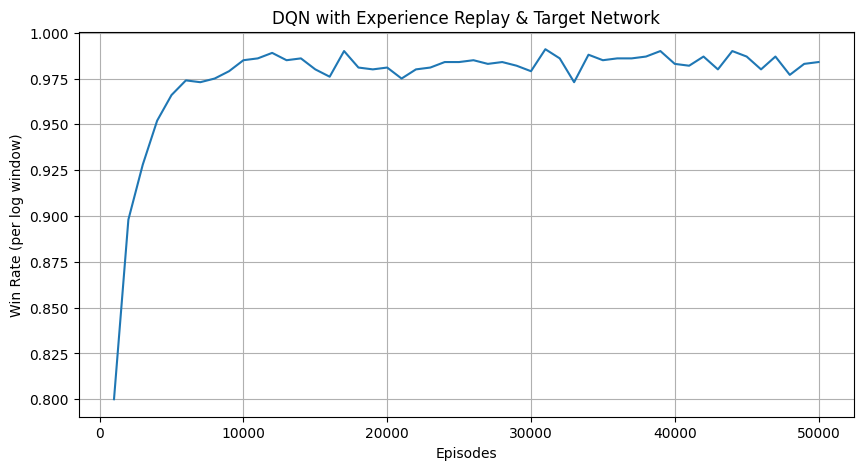

Saved plot to: dqn_training.png


<Figure size 640x480 with 0 Axes>

In [21]:
plot_training(
    checkpoints,
    win_rate_history,
    title="DQN with Experience Replay & Target Network",
    save_path="dqn_training.png"  # set to None if you don't want to save
)


##Play Against Agent

In [22]:
def play_against_agent(agent):
    board = init_board()
    print("\n=== Play Against DQN Agent ===")
    print("You: O | Agent: X")
    print("Positions 0-8:")
    print(" 0 | 1 | 2 ")
    print("-----------")
    print(" 3 | 4 | 5 ")
    print("-----------")
    print(" 6 | 7 | 8 ")

    while True:
        # Agent move
        state = board_to_state(board)
        actions = available_actions(board)
        action = agent.select_action(state, actions, explore=False)
        board[action] = 'X'
        print("\nAgent plays:")
        print_board(board)

        if check_winner(board) == 'X':
            print("Agent wins!")
            break
        if is_draw(board):
            print("Draw!")
            break

        # Human move
        while True:
            try:
                move = int(input("Your move (0-8): "))
                if move in available_actions(board):
                    board[move] = 'O'
                    break
                else:
                    print("Invalid move!")
            except:
                print("Enter 0-8")

        print_board(board)

        if check_winner(board) == 'O':
            print("You win!")
            break
        if is_draw(board):
            print("Draw!")
            break


##Play

In [23]:
play_again = 'y'
while play_again.lower() == 'y':
    play_against_agent(trained_agent)
    play_again = input("\nPlay again? (y/n): ")



=== Play Against DQN Agent ===
You: O | Agent: X
Positions 0-8:
 0 | 1 | 2 
-----------
 3 | 4 | 5 
-----------
 6 | 7 | 8 

Agent plays:


 X |   |   
-----------
   |   |   
-----------
   |   |   

Your move (0-8): 4


 X |   |   
-----------
   | O |   
-----------
   |   |   


Agent plays:


 X | X |   
-----------
   | O |   
-----------
   |   |   

Your move (0-8): 2


 X | X | O 
-----------
   | O |   
-----------
   |   |   


Agent plays:


 X | X | O 
-----------
   | O |   
-----------
 X |   |   

Your move (0-8): 3


 X | X | O 
-----------
 O | O |   
-----------
 X |   |   


Agent plays:


 X | X | O 
-----------
 O | O | X 
-----------
 X |   |   

Your move (0-8): 8


 X | X | O 
-----------
 O | O | X 
-----------
 X |   | O 


Agent plays:


 X | X | O 
-----------
 O | O | X 
-----------
 X | X | O 

Draw!

Play again? (y/n): n
